# Dzyaloshinsky numerical solution

### Here we compute a numerical solution to the Dzyaloshinsky ODE just as a test run

In [85]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
plt.style.use('science')
from scipy.integrate import solve_bvp
from scipy.interpolate import interp1d

### Boundary-value problem solver calls for functions of the form $\frac{dy}{dx} = f(x, y)$ where $y(x), a \leq x \leq b$ is the solution, and $bc(y(a), y(b)) = 0$ is a function which defines the boundary condition.

* See documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html)

### For our problem we have $\frac{d^2 \phi}{d \theta^2} \left[1 - \varepsilon \cos 2 (\phi - \theta)\right] - \left[ 2 \frac{d\phi}{d \theta} - \left( \frac{d\phi}{d\theta} \right)^2 \right] \varepsilon \sin 2 (\phi - \theta) = 0$

### $a = 0, b = \pi, \phi(a) = 0, \phi(b) = \pi / 2$

In [385]:
def f(theta, phi, eps):
    dphi_dtheta = np.zeros(phi.shape)
    dphi_dtheta[0, :] = phi[1, :]
    dphi_dtheta[1, :] = (
                         (2 * phi[1, :] - (phi[1, :])**2)
                         * (eps * np.sin(2 * (phi[0, :] - theta)))
                         / (1 - eps * np.cos(2 * phi[0, :] - theta))
                        )
    
    return dphi_dtheta

def bc(phi_a, phi_b):
    return np.array([phi_a[0], phi_b[0] - 0.5 * np.pi])

### Give initial domain points and initial guess for solution (just isotropic case)

In [386]:
n = 1000

theta0 = np.linspace(0, np.pi, num=n)
phi0 = np.array([theta0 / 2, 0.5 * np.ones(n)])

In [389]:
# Have to use lambda function because solver doesn't let us pass extra args into function
eps = 0
sol = solve_bvp(lambda theta, phi: f(theta, phi, eps), bc, theta0, phi0, verbose=2, max_nodes=100000, tol=1e-10)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          0.00e+00       0.00e+00         1000             0       
Solved in 1 iterations, number of nodes 1000. 
Maximum relative residual: 0.00e+00 
Maximum boundary residual: 0.00e+00


### If we plot, gives the expected output

Text(0, 0.5, '$\\phi$')

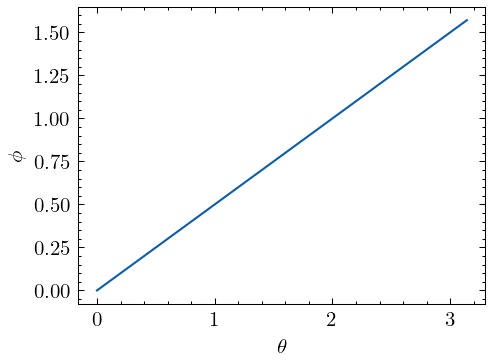

In [402]:
plt.plot(sol.x, sol.y[0, :])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\phi$')

### Write function to give new initial guess from solution (must do this for large $\varepsilon$, otherwise solution does not converge).

In [404]:
def make_new_guess(sol, theta0):

    phi_interp = interp1d(sol.x, sol.y[0, :])
    dphi_interp = interp1d(sol.x, sol.y[1, :])

    phi0 = np.array([phi_interp(theta0), dphi_interp(theta0)])
    
    return phi0

### Run for a few $\varepsilon$ values

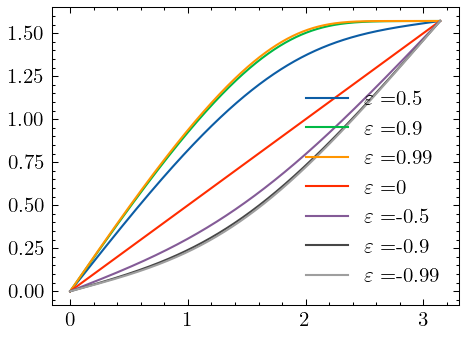

In [414]:
eps_list = [0.5, 0.9, 0.99, 0, -0.5, -0.9, -0.99]
theta_list = []
phi_list = []

for eps in eps_list:
    phi0 = make_new_guess(sol, theta0)
    sol = solve_bvp(lambda theta, phi: f(theta, phi, eps), bc, theta0, phi0, max_nodes=100000, tol=1e-10)
    theta_list.append(sol.x)
    phi_list.append(sol.y)
    
for theta, phi, eps in zip(theta_list, phi_list, eps_list):
    plt.plot(theta, phi[0, :], label=r'$\varepsilon = $' + str(eps))
    
plt.legend()

# Integral form

In [30]:
from scipy.integrate import quadrature
from scipy.optimize import root_scalar

### This doesn't look right so we're going to try the integral form of the equation. This reads:

### $\theta = p \int_0^{\phi - \theta} \sqrt{\frac{1 + \epsilon \cos 2x}{1 + p^2 \epsilon \cos 2x}} dx$

### where $\theta$ is the polar angle and $\phi$ is the director angle, and $p$ is defined by:

### $\pi = (s - 1) p \int_0^\pi \sqrt{\frac{1 + \epsilon \cos 2x}{1 + p^2 \epsilon \cos 2x}} dx$

### with $s$ the defect charge

In [144]:
def p_int(x, p, eps=0):
    
    return p * np.sqrt( (1 + eps * np.cos(2*x)) / (1 + p**2 * eps * np.cos(2*x)) )

def dp_int(x, p, eps=0):
    
    return (
            np.sqrt(p * (eps * np.cos(2*x) + 1) / (eps * p**2 * np.cos(2*x) + 1) )
            * (-eps * p**2 * np.cos(2*x) + 1)
            / (2 * p * (eps * p**2 * np.cos(2*x) + 1))
           )

def p_func(p, s, eps=0):
    
    sol, error = quadrature(p_int, 0, np.pi, args=(p, eps), maxiter=1000)
    sol *= (s - 1)
    return sol - np.pi

def dp_func(p, s, eps=0):
    
    sol, error = quadrature(dp_int, 0, np.pi, args=(p, eps), maxiter=100000)
    sol *= (s - 1)
    return sol

In [146]:
s = 0.5
eps = 0.8
delta = 0.001
lim = 1 / np.sqrt(eps) - delta

p_list = np.linspace(-lim, lim, num=1000)
p_func_list = np.zeros(p_list.shape)
dp_func_list = np.zeros(p_list.shape)

for i in range(p_list.shape[0]):
    p_func_list[i] = p_func(p_list[i], s, eps)

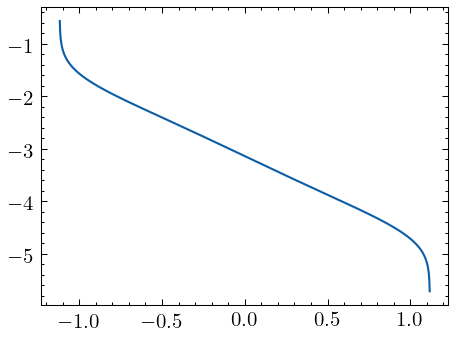

In [147]:
plt.plot(p_list, p_func_list)

In [73]:
s = -0.5
p = -(2 / 3)
eps = 0

sol = p_func(p, s, eps)

In [82]:
zero = root_scalar(p_func, args=(s, eps), x0=1, fprime=dp_func, method='newton')

/tmp/ipykernel_99011/623327896.py:8: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(p * (eps * np.cos(2*x) + 1) / (eps * p**2 * np.cos(2*x) + 1) )
/home/lucas/Application-Data/Paraview/ParaView-5.10.1-MPI-Linux-Python3.9-x86_64/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = nan
  warnings.warn(


In [66]:
import sympy as sym

In [70]:
x, eps, p = sym.symbols('x epsilon p')
expr = sym.sqrt( p * (1 + eps * sym.cos(2 * x)) / (1 + p**2 * eps * sym.cos(2 * x)) )
display( sym.simplify(expr.diff(p)) )

sqrt(p*(epsilon*cos(2*x) + 1)/(epsilon*p**2*cos(2*x) + 1))*(-epsilon*p**2*cos(2*x) + 1)/(2*p*(epsilon*p**2*cos(2*x) + 1))

In [ ]:
(
 np.sqrt(p * (eps * np.cos(2*x) + 1) / (eps * p**2 * np.cos(2*x) + 1) )
 * (-eps * p**2 * np.cos(2*x) + 1)
 / (2 * p * (eps * p**2 * np.cos(2*x) + 1))
)

## Write out weak form

In [149]:
theta, eps = sym.symbols('theta epsilon')
phi = sym.Function('phi')(theta)
f = sym.Function('f')(theta)

In [153]:
expr = -f * (1 - eps * sym.cos(2 * (phi - theta)))

In [154]:
display(sym.simplify(expr.diff(theta)))

2*epsilon*(Derivative(phi(theta), theta) - 1)*f(theta)*sin(2*theta - 2*phi(theta)) + (epsilon*cos(2*theta - 2*phi(theta)) - 1)*Derivative(f(theta), theta)